# Global ms diagnosis on main combination
- compute residual
- compute correlated and uncorrelated part of each term -> evaluate contribution in th H1 hypothesis (correlated part = physical signal)
- evaluate H1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

# Datasets 

In [3]:
def global_ms_drifter_sat_year(dsmean, dsms, alpha):
    #global ms
    ms = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    print(dsms.nb_coloc.sum('drifter_sat_year'))
    for v in dsms.keys():
        if v != 'nb_coloc':
            ms[v].attrs=dsms[v].attrs
    #global mean and var
    mean = (((dsmean*dsmean.nb_coloc).sum('drifter_sat_year'))/(dsmean.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    var = ms-mean**2
    
    #nb_coloc
    nb_coloc = dsms.nb_coloc.sum('drifter_sat_year')

    #error
    from scipy.stats import ncx2
    def get_xlow(mean, var, nb_coloc, alpha):
        df = nb_coloc -1
        nc = df*(mean**2)/var
        norm = df/var
        return ncx2.ppf(alpha/2, df, nc)/norm

    def get_xup(mean, var, nb_coloc, alpha):
        df = nb_coloc -1
        nc = df*(mean**2)/var
        norm = df/var
        return ncx2.ppf(1-alpha/2, df, nc)/norm

    mslow = xr.apply_ufunc(get_xlow, mean, var, nb_coloc, alpha)
    msup = xr.apply_ufunc(get_xup, mean, var, nb_coloc, alpha)
    
    return ms, mslow, msup

In [4]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds_ms, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(131411)


In [5]:
co = [v for v in ds_ms if 'sum_co__' in v and '__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x' in v]
aviso = [v for v in ds_ms if 'sum_aviso__' in v and '__es_cstrio_z15__alti_x' in v]
def cutoff_name(sum_str):
    cutoff_str = {'0':'No filter', '01':'0.1', '02':'0.2', '05':'0.5', '1':'1', '15':'1.5', '2':'2', '25':'2.5'}
    a = sum_str.split('__')[1]
    return cutoff_str[a]
cutoff = [cutoff_name(v) for v in co] 

def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]


df = pd.DataFrame({'cutoff':cutoff,
                   'alongtrack':[float(ds_ms[v].values) for v in co],
                   'alongtrack_error':[float(mserr[v].values) for v in co],
                    'alg_initial_ms':[float(compute_sum_ms(ds_ms, v.replace('sum_','')).values) for v in co],
                   'aviso':[float(ds_ms[v].values) for v in aviso],
                   'aviso_error':[float(mserr[v].values) for v in aviso],
                   'aviso_initial_ms':[float(compute_sum_ms(ds_ms, v.replace('sum_','')).values) for v in aviso],
                  }
                 ).sort_values('cutoff').set_index('cutoff')
df['alongtrack_TER']= df.alongtrack/df.alg_initial_ms*100
df['aviso_TER']= df.aviso/df.aviso_initial_ms*100

In [6]:
df

,alongtrack,alongtrack_error,alg_initial_ms,aviso,aviso_error,aviso_initial_ms,alongtrack_TER,aviso_TER
cutoff,,,,,,,,
0.1,2.064337e-10,2.074428e-12,4.817372e-10,1.030688e-10,1.035727e-12,3.549247e-10,42.851940,29.039630
0.2,1.846718e-10,1.855746e-12,5.501225e-10,9.768334e-11,9.816084e-13,4.233101e-10,33.569222,23.076073
0.5,1.911481e-10,1.920825e-12,6.182359e-10,1.215515e-10,1.221457e-12,4.914234e-10,30.918314,24.734579
1,2.031285e-10,2.041215e-12,6.411308e-10,1.383538e-10,1.390302e-12,5.143184e-10,31.682849,26.900427
1.5,2.091361e-10,2.101584e-12,6.869211e-10,1.471959e-10,1.479154e-12,5.601086e-10,30.445430,26.279884
2,1.962379e-10,1.971972e-12,7.706020e-10,1.663514e-10,1.671645e-12,6.437895e-10,25.465538,25.839401
2.5,1.995959e-10,2.005716e-12,8.042594e-10,1.808654e-10,1.817495e-12,6.774469e-10,24.817360,26.698090
No filter,2.362872e-10,2.374422e-12,8.487367e-10,2.191077e-10,2.201788e-12,7.219242e-10,27.839871,30.350515


Text(0.5, 0, 'Cut off frequency [cpd]')

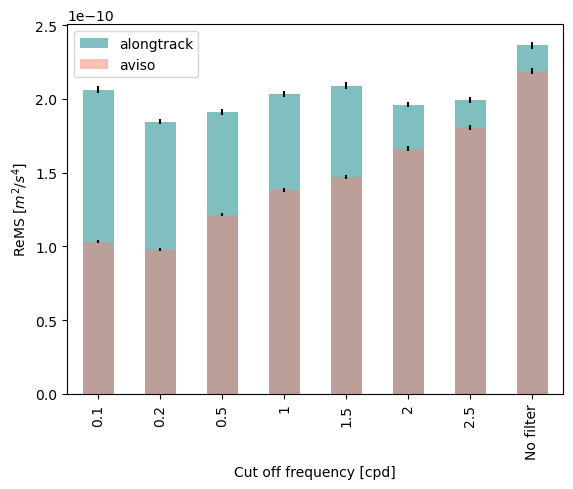

In [7]:
fig, ax = plt.subplots()
df.plot.bar(y='alongtrack',yerr='alongtrack_error', alpha=0.5, color = 'teal', ax=ax)
df.plot.bar(y='aviso', yerr='aviso_error',alpha=0.5, color ='salmon', ax=ax)
plt.ylabel(r'ReMS $[m^2/s^4]$')
plt.xlabel(r'Cut off frequency [cpd]')

Text(0.5, 0, 'Cut off frequency [cpd]')

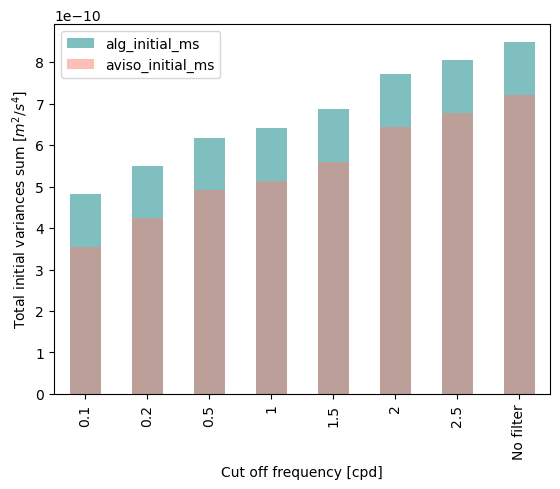

In [8]:
fig, ax = plt.subplots()
df.plot.bar(y='alg_initial_ms', alpha=0.5, color = 'teal', ax=ax)
df.plot.bar(y='aviso_initial_ms', alpha=0.5, color ='salmon', ax=ax)
plt.ylabel(r'Total initial variances sum $[m^2/s^4]$')
plt.xlabel(r'Cut off frequency [cpd]')

Text(0.5, 0, 'Cut off frequency [cpd]')

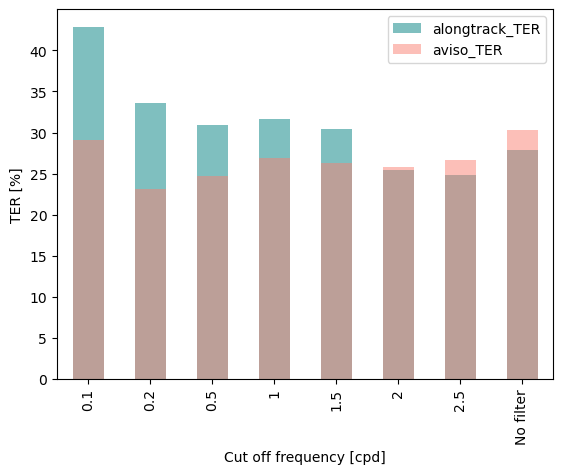

In [13]:
fig, ax = plt.subplots()
df.plot.bar(y='alongtrack_TER', alpha=0.5, color = 'teal', ax=ax)
df.plot.bar(y='aviso_TER',alpha=0.5, color ='salmon', ax=ax)
plt.ylabel('TER [%]')
plt.xlabel('Cut off frequency [cpd]')